### scCODA notebook

Compositional analysis of single cell data
https://sccoda.readthedocs.io/en/latest/getting_started.html

In [ ]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import gseapy as gp

import matplotlib.pyplot as plt
import seaborn as sns

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import sccoda.datasets as scd
import arviz as az

import scvi
import torch
import scipy.sparse as sp

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "/scratch/user/s4575250/BIOX7018_thesis/write/03_sccoda_DA/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "/scratch/user/s4575250/BIOX7018_thesis/figures/PICA0001-PICA0007/03_sccoda"

/Users/jessica/mambaforge/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Abundance analysis (sccoda)

In [ ]:
adata_age= sc.read_h5ad("/scratch/user/s4575250/BIOX7018_thesis/write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_combined_annot_with_age_scvi.h5ad")

In [3]:
# Setup cell type by donor table
ct_table = (
    adata_age.obs.groupby(["pica_id", "cell_type"])
    .size()
    .unstack(fill_value=0)
)

print("ct_table shape:", ct_table.shape)
print(ct_table)

ct_table shape:
(7, 12)

cell_type  CCR6+ memory CD4 T cell  Cytotoxic CD4 T cell  \
pica_id                                                    
PICA0001                        22                    64   
PICA0002                       176                     2   
PICA0003                        18                     2   
PICA0004                        20                     6   
PICA0005                       125                     6   
PICA0006                        14                     0   
PICA0007                        68                     6   

cell_type  Cytotoxic natural killer cell  Efector memory CD8 T cell  \
pica_id                                                               
PICA0001                             446                         23   
PICA0002                             748                         75   
PICA0003                             398                         44   
PICA0004                             811                         19   
PICA0005                            2412                         36   
PICA0006                             662                         61   
PICA0007                             487                         70   

cell_type  GZMK+ memory CD8 T cell  Gamma-delta T cell  NKT cell  \
pica_id                                                            
PICA0001                        11                  96         2   
PICA0002                        91                  88        15   
PICA0003                        43                  73         6   
PICA0004                         8                  67         2   
PICA0005                        52                 513         6   
PICA0006                        24                  57         5   
PICA0007                        40                 215        19   

cell_type  Naive/Central memory CD4 T cell  Naive/Central memory CD8 T cell  \
pica_id                                                                       
PICA0001                              4436                              520   
PICA0002                              1625                              349   
PICA0003                              2203                              386   
PICA0004                              2163                              305   
PICA0005                              1060                              306   
PICA0006                              2953                              651   
PICA0007                              3192                              716   

cell_type  Regulatory T cell  Suppressed CD8 T cell  Tfh / cTfh  
pica_id                                                          
PICA0001                  74                    229         210  
PICA0002                  52                     54         176  
PICA0003                  76                     67          89  
PICA0004                  74                    111         155  
PICA0005                  16                    237         162  
PICA0006                 128                      9         109  
PICA0007                 114                    141         367

In [4]:
# determine reference cell type
stats = pd.DataFrame({
    "nonzero_donors": (ct_table > 0).sum(0),
    "min_count": ct_table.min(0),
    "median_count": ct_table.median(0),
    "cv": (ct_table.std(0) / (ct_table.mean(0) + 1e-9))  # coefficient of variation
}).sort_values(["nonzero_donors", "median_count", "cv"], ascending=[False, False, True])

print(stats.head(8))


nonzero_donors  min_count  median_count  \
cell_type                                                                  
Naive/Central memory CD4 T cell               7       1060        2203.0   
Cytotoxic natural killer cell                 7        398         662.0   
Naive/Central memory CD8 T cell               7        305         386.0   
Tfh / cTfh                                    7         89         162.0   
Suppressed CD8 T cell                         7          9         111.0   
Gamma-delta T cell                            7         57          88.0   
Regulatory T cell                             7         16          74.0   
Efector memory CD8 T cell                     7         19          44.0   

                                       cv  
cell_type                                  
Naive/Central memory CD4 T cell  0.442997  
Cytotoxic natural killer cell    0.828051  
Naive/Central memory CD8 T cell  0.365663  
Tfh / cTfh                       0.504690  
Suppressed CD8 T cell            0.719384  
Gamma-delta T cell               1.042669  
Regulatory T cell                0.488473  
Efector memory CD8 T cell        0.477119

### Naive/Central memory CD4 T cell has all donors, high median count and lowest cv

## Creating scCODA object for larger datasets
- using Age_group instead of Age in years int

In [ ]:
meta_df = (
    adata_age.obs[["pica_id", "Age_group"]]
    .drop_duplicates()
    .set_index("pica_id")
)

meta_df

In [ ]:
# merge donor metadata into the counts table
ct_table_with_meta = ct_table.merge(meta_df, left_index=True, right_index=True)

# create scCODA data object
sccoda_data = dat.from_pandas(ct_table_with_meta, ["Age_group"])

print(sccoda_data)

In [ ]:
# run scCODA compositional analysis
model = mod.CompositionalAnalysis(
    formula="Age_group",                            
    data=sccoda_data,
    reference_cell_type="Naive/Central memory CD4 T cell"  
)
age_results = model.sample_hmc(20000, 4)

In [ ]:
summary = age_results.summary()
print(summary)

viz.plot_effects(model)
viz.plot_inclusion_probabilities(model)

## creating scCODA object for smaller datasets ( 1 batch)
- using Age in years int instead of Age_group

In [5]:
meta_df = (
    adata_age.obs[["pica_id", "Age in years int"]]
    .drop_duplicates()
    .set_index("pica_id")
)

meta_df

,Age in years int
pica_id,
PICA0007,3
PICA0002,15
PICA0001,2
PICA0003,0
PICA0006,0
PICA0004,3
PICA0005,9


In [6]:
meta_df.rename(columns={"Age in years int": "Age_in_years_int"}, inplace=True)

# merge donor metadata into the counts table
ct_table_with_meta = ct_table.merge(meta_df, left_index=True, right_index=True)

# create scCODA data object
sccoda_data = dat.from_pandas(ct_table_with_meta, ["Age_in_years_int"])

print(sccoda_data)

AnnData object with n_obs × n_vars = 7 × 12
    obs: 'Age_in_years_int'

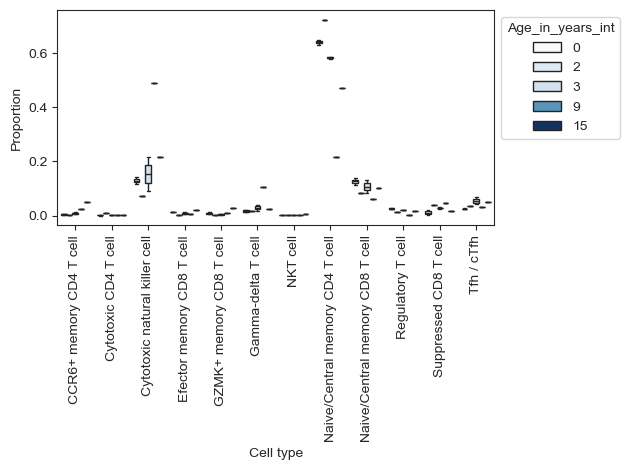

<Figure size 640x480 with 0 Axes>

In [ ]:
# check input to scCODA
viz.boxplots(sccoda_data, feature_name="Age_in_years_int")
plt.show()
plt.savefig("/scratch/user/s4575250/BIOX7018_thesis/figures/PICA0001-PICA0007/03_sccoda/PICA0001-PICA0007_QC_scCODA_input_proportions.png", dpi=300)

In [35]:
# run scCODA compositional analysis
model = mod.CompositionalAnalysis(
    formula="Age_in_years_int",                            
    data=sccoda_data,
    reference_cell_type="Naive/Central memory CD4 T cell"  
)
age_results = model.sample_hmc(5000, 1000)

Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 5000/5000 [00:11<00:00, 452.53it/s]


MCMC sampling finished. (15.636 sec)
Acceptance rate: 86.6%


In [36]:
age_results.summary()

Compositional Analysis summary:

Data: 7 samples, 12 cell types
Reference index: 7
Formula: Age_in_years_int

Intercepts:
                                 Final Parameter  Expected Sample
Cell Type                                                        
CCR6+ memory CD4 T cell                   -0.267        77.497562
Cytotoxic CD4 T cell                      -1.234        29.466278
Cytotoxic natural killer cell              1.813       620.326825
Efector memory CD8 T cell                 -0.244        79.300662
GZMK+ memory CD8 T cell                   -0.546        58.629998
Gamma-delta T cell                         0.427       155.127363
NKT cell                                  -1.121        32.991385
Naive/Central memory CD4 T cell            3.214      2518.066127
Naive/Central memory CD8 T cell            1.630       516.588426
Regulatory T cell                          0.133       115.612777
Suppressed CD8 T cell                      0.215       125.492560
Tfh / cTfh          

1) Intercepts: baseline (avg) log-relative abundance of each cell type when age is 0

2) Effects: log-fold changes with age
- positve: cell type increase with age
- negative: cell type decrease with age

In [37]:
# credible effect summary
credible=age_results.credible_effects().reset_index()
print(credible)

Covariate                        Cell Type  Final Parameter
0   Age_in_years_int          CCR6+ memory CD4 T cell            False
1   Age_in_years_int             Cytotoxic CD4 T cell            False
2   Age_in_years_int    Cytotoxic natural killer cell             True
3   Age_in_years_int        Efector memory CD8 T cell            False
4   Age_in_years_int          GZMK+ memory CD8 T cell            False
5   Age_in_years_int               Gamma-delta T cell            False
6   Age_in_years_int                         NKT cell            False
7   Age_in_years_int  Naive/Central memory CD4 T cell            False
8   Age_in_years_int  Naive/Central memory CD8 T cell            False
9   Age_in_years_int                Regulatory T cell            False
10  Age_in_years_int            Suppressed CD8 T cell            False
11  Age_in_years_int                       Tfh / cTfh            False

95% credibile interval of age effect -> TRUE: confidence that age has a real influence on cell types' proportion 
- only Cytotoxic natural killer cell showed a credible difference with age, while all others do not

In [ ]:
intercepts_df = age_results.intercept_df.reset_index()
effects_df = age_results.effect_df.reset_index()

intercepts_df.to_csv("/scratch/user/s4575250/BIOX7018_thesis/figures/PICA0001-PICA0007/03_sccoda/age_sccoda_intercepts.csv", index=False)
effects_df.to_csv("/scratch/user/s4575250/BIOX7018_thesis/figures/PICA0001-PICA0007/03_sccoda/age_sccoda_effects.csv", index=False)
credible.to_csv("/scratch/user/s4575250/BIOX7018_thesis/figures/PICA0001-PICA0007/03_sccoda/age_sccoda_credible_effects.csv", index=False)

In [39]:
# extract coefficients summary dataframe
summary_df = az.summary(age_results)
print(summary_df.head())

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  \
alpha[CCR6+ memory CD4 T cell]       -0.267  0.379  -0.998    0.379   
alpha[Cytotoxic CD4 T cell]          -1.234  0.398  -1.979   -0.549   
alpha[Cytotoxic natural killer cell]  1.813  0.240   1.364    2.264   
alpha[Efector memory CD8 T cell]     -0.244  0.359  -0.862    0.448   
alpha[GZMK+ memory CD8 T cell]       -0.546  0.401  -1.317    0.145   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha[CCR6+ memory CD4 T cell]            0.048    0.040      70.0      85.0   
alpha[Cytotoxic CD4 T cell]               0.051    0.020      61.0     202.0   
alpha[Cytotoxic natural killer cell]      0.028    0.011      74.0     162.0   
alpha[Efector memory CD8 T cell]          0.052    0.038      56.0     109.0   
alpha[GZMK+ memory CD8 T cell]            0.060    0.031      45.0     126.0   

                                      r_hat  
alpha[CCR6+ memory CD4 T cell]          NaN  
alpha[Cytotoxic CD4 T cell]             NaN  
alpha[Cytotoxic natural killer cell]    NaN  
alpha[Efector memory CD8 T cell]        NaN  
alpha[GZMK+ memory CD8 T cell]          NaN

In [40]:
# subset regression coefficients
coef_df = summary_df[summary_df.index.str.contains("beta", case=False)].copy()
print(coef_df.head())

mean     sd  hdi_3%  \
beta[Age_in_years_int, CCR6+ memory CD4 T cell]     0.021  0.044  -0.023   
beta[Age_in_years_int, Cytotoxic CD4 T cell]        0.004  0.030  -0.059   
beta[Age_in_years_int, Cytotoxic natural killer...  0.055  0.028  -0.000   
beta[Age_in_years_int, Efector memory CD8 T cell]   0.009  0.025  -0.019   
beta[Age_in_years_int, GZMK+ memory CD8 T cell]     0.019  0.040  -0.025   

                                                    hdi_97%  mcse_mean  \
beta[Age_in_years_int, CCR6+ memory CD4 T cell]       0.125      0.026   
beta[Age_in_years_int, Cytotoxic CD4 T cell]          0.068      0.004   
beta[Age_in_years_int, Cytotoxic natural killer...    0.099      0.003   
beta[Age_in_years_int, Efector memory CD8 T cell]     0.078      0.004   
beta[Age_in_years_int, GZMK+ memory CD8 T cell]       0.120      0.018   

                                                    mcse_sd  ess_bulk  \
beta[Age_in_years_int, CCR6+ memory CD4 T cell]       0.015       4.0   
beta[Age_in_years_int, Cytotoxic CD4 T cell]          0.003      60.0   
beta[Age_in_years_int, Cytotoxic natural killer...    0.002      66.0   
beta[Age_in_years_int, Efector memory CD8 T cell]     0.006      36.0   
beta[Age_in_years_int, GZMK+ memory CD8 T cell]       0.009       8.0   

                                                    ess_tail  r_hat  
beta[Age_in_years_int, CCR6+ memory CD4 T cell]         38.0    NaN  
beta[Age_in_years_int, Cytotoxic CD4 T cell]           147.0    NaN  
beta[Age_in_years_int, Cytotoxic natural killer...      66.0    NaN  
beta[Age_in_years_int, Efector memory CD8 T cell]       41.0    NaN  
beta[Age_in_years_int, GZMK+ memory CD8 T cell]         87.0    NaN

In [41]:
# parse cell type from index and sort by mean coefficient
coef_df = coef_df.reset_index()
coef_df["cell_type"] = coef_df["index"].str.extract(r", (.*?)\]")
coef_df = coef_df.sort_values("mean", ascending=False)
print(coef_df.head())

index   mean     sd  hdi_3%  \
2  beta[Age_in_years_int, Cytotoxic natural kille...  0.055  0.028  -0.000   
0    beta[Age_in_years_int, CCR6+ memory CD4 T cell]  0.021  0.044  -0.023   
4    beta[Age_in_years_int, GZMK+ memory CD8 T cell]  0.019  0.040  -0.025   
5         beta[Age_in_years_int, Gamma-delta T cell]  0.013  0.029  -0.028   
3  beta[Age_in_years_int, Efector memory CD8 T cell]  0.009  0.025  -0.019   

   hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  \
2    0.099      0.003    0.002      66.0      66.0    NaN   
0    0.125      0.026    0.015       4.0      38.0    NaN   
4    0.120      0.018    0.009       8.0      87.0    NaN   
5    0.080      0.004    0.003      33.0      92.0    NaN   
3    0.078      0.004    0.006      36.0      41.0    NaN   

                       cell_type  
2  Cytotoxic natural killer cell  
0        CCR6+ memory CD4 T cell  
4        GZMK+ memory CD8 T cell  
5             Gamma-delta T cell  
3      Efector memory CD8 T cell

In [42]:
print(coef_df.columns)

Index(['index', 'mean', 'sd', 'hdi_3%', 'hdi_97%', 'mcse_mean', 'mcse_sd',
       'ess_bulk', 'ess_tail', 'r_hat', 'cell_type'],
      dtype='object')

In [43]:
coef_df.rename(columns={"hdi_3%": "hdi_3", "hdi_97%": "hdi_97"}, inplace=True)

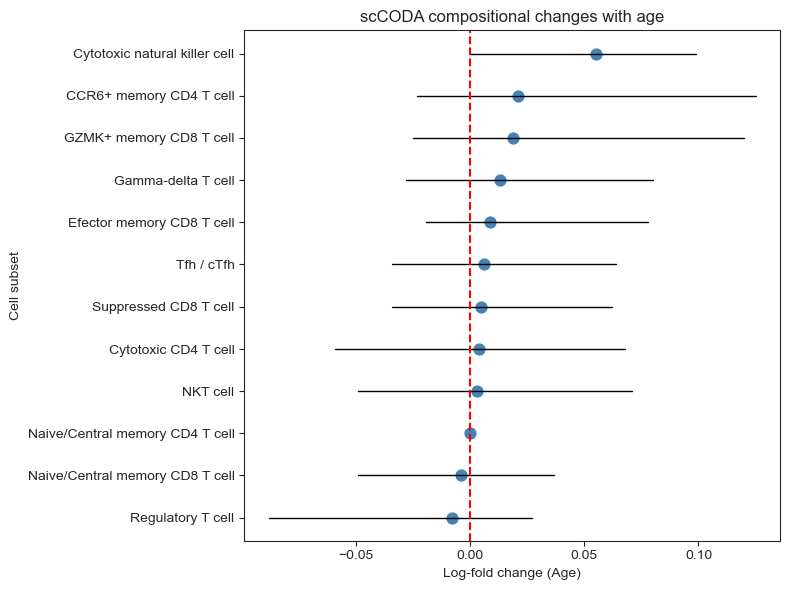

In [52]:
# forest plot of compositional analysis results
plt.figure(figsize=(8,6))

sns.pointplot(
    data=coef_df,
    x="mean",
    y="cell_type",
    join=False,
    color="steelblue"
)

# add credible intervals (HDI)
for i, row in enumerate(coef_df.itertuples()):
    plt.plot([row.hdi_3, row.hdi_97], [i, i], color="black", lw=1)

plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Log-fold change (Age)")
plt.ylabel("Cell subset")
plt.title("scCODA compositional changes with age")
plt.tight_layout()
plt.savefig("../../../figures/PICA0001-PICA0007/03_sccoda/PICA0001-PICA0007_scCODA_forest_plot.png", dpi=300)
plt.show()


In [45]:
# add credible effect column
coef_df["credible"] = ~((coef_df["hdi_3"] < 0) & (coef_df["hdi_97"] > 0))
print(coef_df.head())

index   mean     sd  hdi_3  \
2  beta[Age_in_years_int, Cytotoxic natural kille...  0.055  0.028 -0.000   
0    beta[Age_in_years_int, CCR6+ memory CD4 T cell]  0.021  0.044 -0.023   
4    beta[Age_in_years_int, GZMK+ memory CD8 T cell]  0.019  0.040 -0.025   
5         beta[Age_in_years_int, Gamma-delta T cell]  0.013  0.029 -0.028   
3  beta[Age_in_years_int, Efector memory CD8 T cell]  0.009  0.025 -0.019   

   hdi_97  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  \
2   0.099      0.003    0.002      66.0      66.0    NaN   
0   0.125      0.026    0.015       4.0      38.0    NaN   
4   0.120      0.018    0.009       8.0      87.0    NaN   
5   0.080      0.004    0.003      33.0      92.0    NaN   
3   0.078      0.004    0.006      36.0      41.0    NaN   

                       cell_type  credible  
2  Cytotoxic natural killer cell      True  
0        CCR6+ memory CD4 T cell     False  
4        GZMK+ memory CD8 T cell     False  
5             Gamma-delta T cell     False  
3      Efector memory CD8 T cell     False

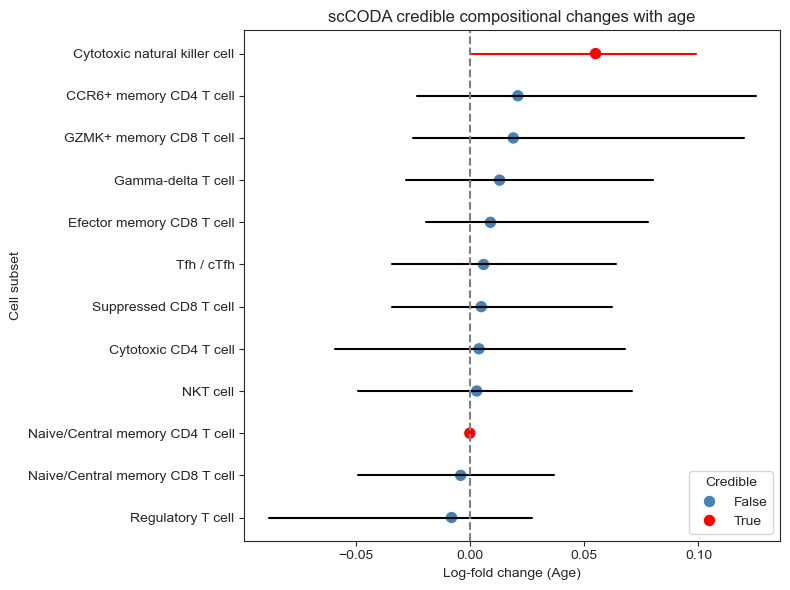

In [ ]:
# forest plot hihglighting credible effects
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=coef_df,
    x="mean", y="cell_type",
    hue="credible", palette={True: "red", False: "steelblue"},
    s=80
)

for i, row in enumerate(coef_df.itertuples()):
    plt.plot([row.hdi_3, row.hdi_97], [i, i],
             color="black" if not row.credible else "red", lw=1.5)

plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Log-fold change (Age)")
plt.ylabel("Cell subset")
plt.title("scCODA credible compositional changes with age")
plt.legend(title="Credible", loc="lower right")
plt.tight_layout()
plt.savefig("/scratch/user/s4575250/BIOX7018_thesis/figures/PICA0001-PICA0007/03_sccoda/PICA0001-PICA0007_scCODA_forest_plot_colored.png", dpi=300)
plt.show()

In [ ]:
# inclusion probability plot
posterior = age_results.posterior
beta_vars = [v for v in posterior.data_vars if "beta" in v]

for var in beta_vars:
    mean_val = posterior[var].mean().values
    hdi = az.hdi(posterior[var])
    print(f"{var}: mean={mean_val}, HDI={hdi}")
    
plt.savefig("/scratch/user/s4575250/BIOX7018_thesis/figures/PICA0001-PICA0007/03_sccoda/PICA0001-PICA0007_sccoda_prob_plot.png", dpi=300)


beta: mean=0.010350266004357228, HDI=<xarray.Dataset> Size: 2kB
Dimensions:    (covariate: 1, cell_type: 12, hdi: 2)
Coordinates:
  * cell_type  (cell_type) <U31 1kB 'CCR6+ memory CD4 T cell' ... 'Tfh / cTfh'
  * covariate  (covariate) <U16 64B 'Age_in_years_int'
  * hdi        (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta       (covariate, cell_type, hdi) float64 192B -0.02294 ... 0.06441

<Figure size 640x480 with 0 Axes>

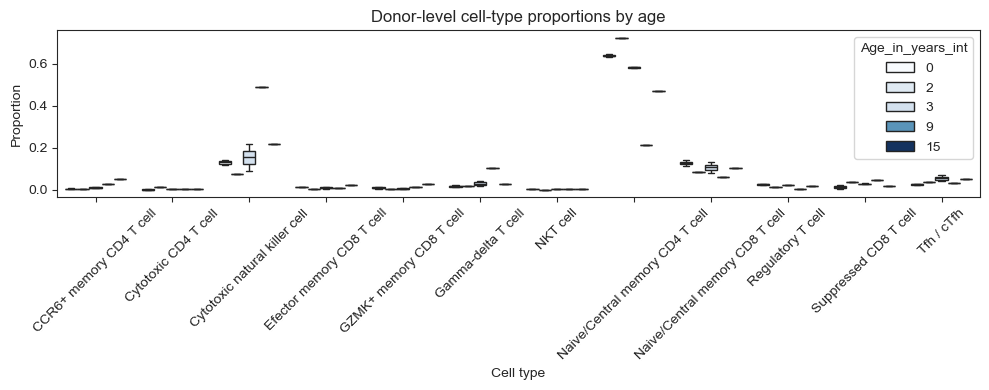

In [ ]:
# Convert raw cell counts to proportions per donor
prop_df = ct_table_with_meta.div(ct_table_with_meta.sum(axis=1), axis=0)
prop_df["Age_in_years_int"] = meta_df["Age_in_years_int"]

# Melt for plotting
prop_melt = prop_df.reset_index().melt(
    id_vars=["pica_id", "Age_in_years_int"],
    var_name="Cell type",
    value_name="Proportion"
)

plt.figure(figsize=(10,4))
sns.boxplot(
    data=prop_melt,
    x="Cell type",
    y="Proportion",
    hue="Age_in_years_int",
    palette="Blues"
)
plt.title("Donor-level cell-type proportions by age")
plt.xticks(rotation=45)
plt.tight_layout()    
plt.savefig("/scratch/user/s4575250/BIOX7018_thesis/figures/PICA0001-PICA0007/03_sccoda/PICA0001-PICA0007_sccoda_raw_donor_level_prop.png", dpi=300)
plt.show()

In [49]:
# save ssconda config
adata_age.uns["sccoda_config"] = {
    "formula": "Age_in_years_int",
    "reference_cell_type": "Naive/Central memory CD4 T cell",
    "hmc_draws": 5000,    
    "hmc_burnin": 2000,   
    "acceptance_rate": float(75.7),  # fill from your run
    "pseudocount": 0.5
}

In [ ]:
adata_age.uns["sccoda_summary"] = coef_df.to_dict("list")

# Save AnnData
adata_age.write_h5ad("/scratch/user/s4575250/BIOX7018_thesis/write/03_sccoda_DA/PICA0001-PICA0007/PICA0001-PICA0007_age_sccoda.h5ad", compression="gzip")

In [51]:
# load 
coef_df = pd.DataFrame(adata_age.uns["sccoda_summary"])
print(coef_df.head())

index   mean     sd  hdi_3  \
0  beta[Age_in_years_int, Cytotoxic natural kille...  0.055  0.028 -0.000   
1    beta[Age_in_years_int, CCR6+ memory CD4 T cell]  0.021  0.044 -0.023   
2    beta[Age_in_years_int, GZMK+ memory CD8 T cell]  0.019  0.040 -0.025   
3         beta[Age_in_years_int, Gamma-delta T cell]  0.013  0.029 -0.028   
4  beta[Age_in_years_int, Efector memory CD8 T cell]  0.009  0.025 -0.019   

   hdi_97  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  \
0   0.099      0.003    0.002      66.0      66.0    NaN   
1   0.125      0.026    0.015       4.0      38.0    NaN   
2   0.120      0.018    0.009       8.0      87.0    NaN   
3   0.080      0.004    0.003      33.0      92.0    NaN   
4   0.078      0.004    0.006      36.0      41.0    NaN   

                       cell_type  credible  
0  Cytotoxic natural killer cell      True  
1        CCR6+ memory CD4 T cell     False  
2        GZMK+ memory CD8 T cell     False  
3             Gamma-delta T cell     False  
4      Efector memory CD8 T cell     False